# Logistic Regression Demonstration - Height / weight
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

**Note:** This mini-project shows some logistic regression techniques. It is based on [Lab 5 in the CS109](https://github.com/cs109/2015lab5) course.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

## Getting data and examining basic relationship

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


## Creating a scatterplot of height and weight by gender

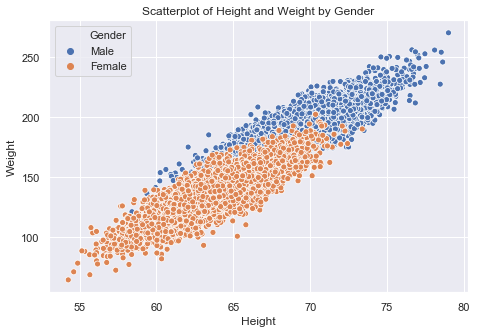

In [10]:

fig = plt.gcf()
_= fig.set_size_inches(7.5,5, forward=True)
_ = sns.set(font_scale=1)
_ = sns.scatterplot(x='Height', y='Weight', data=dflog, hue='Gender', legend='brief')
_ = plt.title('Scatterplot of Height and Weight by Gender')

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)

clf = LogisticRegression(solver='lbfgs')
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9252


### Tuning the Model

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [33]:
clf = LogisticRegression(solver='lbfgs')
score = cv_score(clf, Xlr, ylr)
print(score)

0.9172


In [31]:
def cv_score_train(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[train]), y[train]) # evaluate score function on held-out data
    return result / nfold # average

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
scores=[]
score_max=0
c_max=[]
for i in Cs:
    clf = LogisticRegression(solver='lbfgs', C=i)
    scores = cv_score_train(clf, Xlr, ylr)
    if scores > score_max:
        score_max=scores
        c_max = i
    print("For C = {}, accuracy score is {:.3f}".format(i, scores))
print('C of {} gives max accuracy of {:.3f}'.format(c_max, score_max))

For C = 0.001, accuracy score is 0.912
For C = 0.1, accuracy score is 0.917
For C = 1, accuracy score is 0.917
For C = 10, accuracy score is 0.917
For C = 100, accuracy score is 0.917
C of 0.1 gives max accuracy of 0.917


## Refit the model with best parameter

Below, we refit the model using the best hyper-paramater estimate.
We note that the accuracy (.917) is is a little lower than the acccuracy from the model fitted only with cross-validation (.925). While it may seem strange that the cross-validated model produced better results, this seems entirely due to choosing a particular good RNG seed, other values gives lower accuracy.

In [34]:
clf = LogisticRegression(solver='lbfgs', C=0.1)
score = cv_score(clf, Xlr, ylr)
print(score)

0.9172


### Black Box Grid Search in `sklearn`

We do the same search below but using SKLearn's GridSearchCV function. The accuracy to the test set is .917, the same as using the training set only (which we did earlier). This is good, we don't see a drop in accuracy when we get to the test set.

In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.001, 0.1, 1, 10, 100]}
logreg = LogisticRegression(solver='lbfgs')
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(Xlr, ylr)
print("The accuracy is {:.3f}".format(logreg_cv.best_score_))

The accuracy is 0.917
